In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [3]:
# Hyper Parameters
EPOCH = 20
BATCH_SIZE = 64
LR = 0.005
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [4]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    
    download=DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])
torch.Size([60000])


C:\Users\74496\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\74496\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


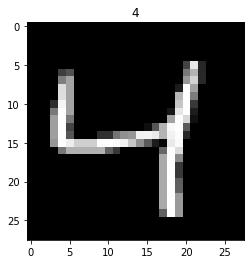

In [5]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [6]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),      # compress to a range (0, 1)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
autoencoder = AutoEncoder()
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [9]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [10]:
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

Epoch:  0  | train loss: 0.2330


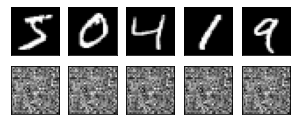

Epoch:  0  | train loss: 0.0607


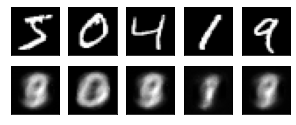

Epoch:  5  | train loss: 0.0383


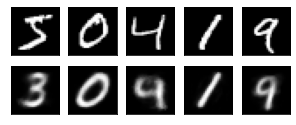

Epoch:  5  | train loss: 0.0409


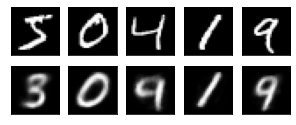

Epoch:  10  | train loss: 0.0356


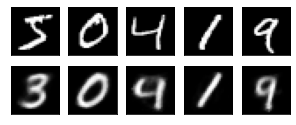

Epoch:  10  | train loss: 0.0351


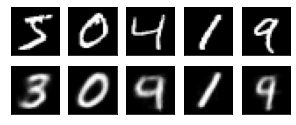

Epoch:  15  | train loss: 0.0384


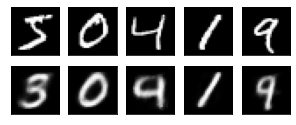

Epoch:  15  | train loss: 0.0395


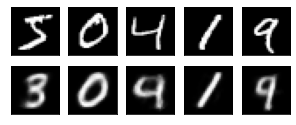

Epoch:  19  | train loss: 0.0355


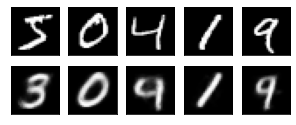

Epoch:  19  | train loss: 0.0353


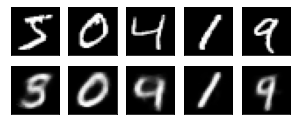

In [11]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))
        b_y = Variable(x.view(-1, 28*28))      # same input and output
        b_label = Variable(y)
        
        encoded, decoded = autoencoder(b_x)
        
        loss = loss_func(decoded, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 500 == 0 and epoch in [0, 5, 10, 15, EPOCH-1]:
            print('Epoch: ', epoch, ' | train loss: %.4f' % loss.data)
            
            # plotting decode image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
                
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
                
            plt.show(); plt.pause(0.05) 

C:\Users\74496\AppData\Local\Temp/ipykernel_3504/3099551936.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  fig = plt.figure(2); ax = Axes3D(fig)


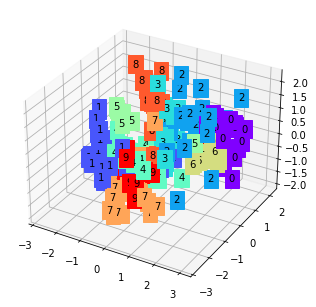

In [12]:
# visualize in 3D plot
view_data = Variable(train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()